In [2]:
!pip -q install pybboxes
!pip -q install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.3 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import os
import pandas as pd
import pickle
from tqdm.auto import tqdm
import pybboxes as pybbx
from matplotlib import pyplot as plt
import math
import copy


import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet
import torchvision.transforms as transforms
from torchmetrics import Accuracy

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UCODE_DICT = '/content/drive/MyDrive/Resource/Data/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl'

# Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/
# !pip install kaggle
!mkdir -v ~/.kaggle

!cp -f "/content/drive/MyDrive/Thesis Resource/kaggle.json" ~/.kaggle
!kaggle datasets download -d ngcthunhb/nomdataset-crops

/content
mkdir: created directory '/root/.kaggle'
Dataset URL: https://www.kaggle.com/datasets/ngcthunhb/nomdataset-crops
License(s): unknown
 89% 161M/182M [00:03<00:00, 53.4MB/s]
100% 182M/182M [00:03<00:00, 55.3MB/s]


In [6]:
!unzip -q /content/nomdataset-crops.zip -d dataset/

## NomImageDataset - For loading raw-cropped images

In [7]:
# Dataset class for inputting YoloV5
class NomImageDataset(Dataset):
    def __init__(self, image_dir, annotation_file, unicode_dict_path, image_size=(224, 224), transform=None):
        self.root_dir = image_dir
        self.label_list = list()
        self.image_list = list()
        self.unicode_dict = dict()
        self.transform = transform
        self.image_size = image_size
        self.n_crop = 0

        with open(unicode_dict_path, 'rb') as f:
            tmp = pickle.load(f)
            tmp = sorted(list(tmp.keys()))
        for idx, k in enumerate(tmp):
            self.unicode_dict[k] = idx

        with open(annotation_file, 'r') as f:
            for line in tqdm(f):
                line = line.strip().split(',')
                image_name, label = line
                label = label.strip()
                image_path = os.path.join(self.root_dir, image_name)

                self.image_list.append(image_path)
                try:
                    self.label_list.append(self.unicode_dict[label])
                except:
                    self.label_list.append(self.unicode_dict['UNK'])
                    # print(f'Unknown label: {label}')

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        x_image = cv2.imread(self.image_list[idx])
        y_label = self.label_list[idx]
        x_image = cv2.cvtColor(x_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            x_image = self.transform(x_image)
        else:
            x_image = x_image *  1.0 / 255
            x_image = cv2.resize(x_image, self.image_size, interpolation=cv2.INTER_LANCZOS4)
            # x_image = (x_image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
            x_image = torch.from_numpy(x_image).permute(2, 0, 1).float()
        y_label = torch.tensor(y_label, dtype=torch.long)
        return x_image, y_label

# opt = dict(
#     image_dir = '../NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1871/1871-raw-images',
#     annotation_file = '../TempResources/ToK1871.txt',
#     unicode_dict_path = '../NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst-label-set-ucode.pkl',
#     transform = None,
# )
# dataset = NomImageDataset(**opt)

# from matplotlib import pyplot as plt
# img = dataset[2][0]
# detBoxes = dataset[2][1]


# textLabel = []
# for box in detBoxes:
#     x_tl, y_tl, x_br, y_br, label = box
#     cv2.rectangle(img, (x_tl, y_tl), (x_br, y_br), (0, 255, 0), 2)
#     cv2.putText(img, label, (x_tl, y_tl), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
#     textLabel.append(chr(int(label, 16)))
# plt.imshow(img)
# plt.show()

# print(textLabel)

class ImageCropDataset(Dataset):
    """ Image Crop Dataset Loader, used for loading Crop images and labels of crop image

    Args:
        crop_path (str): Path to the directory containing the crop images.
        label_path (str): Path to the file containing the labels of the crop images.
        input_size (tuple(int, int)): Image size to return.
        ucode_dict_path (str): Path to the file containing the unicode dictionary. For translate unicode to dictionary index
        transforms (Callable): Transforms to apply to the crop images.

    """
    def __init__(self, crop_path : str, label_path : str, input_size, ucode_dict : dict, transforms):
        self.crop_path = crop_path
        self.label_path = label_path
        self.ucode_dict = ucode_dict
        self.transforms = transforms

        self.input_size = input_size
        self.num_labels = 0

        self.crop_list = []
        self.labels_list = []

        def read_crop_and_label(crop_path, label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    line = line.split(', ')
                    self.labels_list.append(line[1].strip())
                    crop = line[0].strip()
                    # Check path exists
                    if not os.path.exists(os.path.join(crop_path, crop)):
                        raise FileNotFoundError(f'Crop image {os.path.join(crop_path, crop)} not found')
                    else:
                        self.crop_list.append(crop)

        read_crop_and_label(crop_path, label_path)

        assert self.crop_list is not None, 'No crop images found'
        assert self.labels_list is not None, 'No labels found'
        assert self.ucode_dict is not None, 'No unicode dictionary found'
        assert len(self.crop_list) == len(self.labels_list), 'Number of crops and labels do not match'

        # Display statistics of dataset
        print(f'Number of crops: {len(self.crop_list)}')
        print(f'Number of labels: {self.num_labels}')
        print(f'Crop images shape: {self.input_size}')
        print(f'Number of unique labels: {len(self.ucode_dict)}')

    def __len__(self):
        return len(self.crop_list)

    def __getitem__(self, idx):
        assert idx < len(self), 'Index out of range'
        img_path = os.path.join(self.crop_path, self.crop_list[idx])
        x_crop_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        h, w, _ = x_crop_img.shape
        if (h, w) != self.input_size:
            x_crop_img = cv2.resize(x_crop_img, self.input_size, cv2.INTER_LANCZOS4)

        if transforms is not None:
            x_crop_img = self.transforms(x_crop_img).float()
        else:
            x_crop_img = torch.tensor(x_crop_img).float()

        y_label = self.labels_list[idx]
        try:
            y_label = self.ucode_dict[y_label]
        except KeyError:
            # TODO: Handle unknown labels, cuz current dict does not have all Sino-Nom ucode
            y_label = self.ucode_dict['UNK']
        y_label = torch.tensor(y_label, dtype=torch.long)

        return x_crop_img, y_label

class ImageCropDataModule(pl.LightningDataModule):
    def __init__(self, data_dirs : dict, ucode_dict_path : str, input_size, batch_size : int, num_workers : int, transforms=None):
        super().__init__()
        self.data_dir = data_dirs
        self.ucode_dict_path = ucode_dict_path
        
        self.input_size = input_size
        self.transforms = transforms

        self.batch_size = batch_size
        self.num_workers = num_workers
        
        def read_ucode_dict(ucode_dict_path):
            with open(ucode_dict_path, 'rb') as f:
                ucode_dict = pickle.load(f)
            for i, (k, v) in enumerate(ucode_dict.items()):
                ucode_dict[k] = i
            return ucode_dict
        self.ucode_dict = read_ucode_dict(ucode_dict_path)

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = ImageCropDataset(self.data_dir['train'][0], self.data_dir['train'][1], self.input_size, self.ucode_dict, self.transforms)
            self.val_dataset = ImageCropDataset(self.data_dir['val'][0], self.data_dir['val'][1], self.input_size, self.ucode_dict, self.transforms)
        elif stage == 'test':
            self.test_dataset = ImageCropDataset(self.data_dir['test'][0], self.data_dir['test'][1], self.input_size, self.ucode_dict, self.transforms)
        elif stage is None:
            pass
        else:
            raise ValueError(f"Stage {stage} not recognized")


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# Architectures

## Recognizer : Nom_Resnet101

In [8]:
class Nom_Resnet101(nn.Module):
    def __init__(self, n_classes, pretrained=True):
        super(Nom_Resnet101, self).__init__()
        self.model = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)

        # Modify the last layer
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

class PytorchResNet101(pl.LightningModule):
    def __init__(self, num_labels):
        super(PytorchResNet101, self).__init__()
        self.save_hyperparameters()
        self.num_labels = num_labels

        # Get ResNet architecture and remove the last FC layer
        backbone = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]

        # Initialize layers
        self.feature_extractor = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_filters, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()
        self.metrics = Accuracy(task="multiclass", num_classes=self.num_labels)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## Super-Resolution Generator: SRCNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self, architecture : str) -> None:
        super(SRCNN, self).__init__()

        if architecture not in ["915", "935", "955"]:
            raise ValueError("architecture must be 915, 935 or 955")
        k = int(architecture[1])

        self.patch_extraction = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9)
        nn.init.normal_(self.patch_extraction.weight, mean=0.0, std=0.001)
        nn.init.zeros_(self.patch_extraction.bias)

        self.nonlinear_map = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=k)
        nn.init.normal_(self.nonlinear_map.weight, mean=0.0, std=0.001)
        nn.init.zeros_(self.nonlinear_map.bias)

        self.recon = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5)
        nn.init.normal_(self.recon.weight, mean=0.0, std=0.001)
        nn.init.zeros_(self.recon.bias)

    def forward(self, X_in):
        X = F.relu(self.patch_extraction(X_in))
        X = F.relu(self.nonlinear_map(X))
        X = self.recon(X)
        X_out = torch.clip(X, 0.0, 1.0)
        return X_out


# Training Resnet with SR images

In [ ]:
from data.NomDataset import ImageCropDataModule

opt = dict(
    name='ToK1871_SR-RealESRGANx4_RealCE',
    max_epochs=100,
    model_mode='train',
    data_dirs=dict(
        train=[
            'ToK1871/ToK1871_mixedSR_crops', 
            'ToK1871/ToK1871_mixedSR_crops.txt'
        ],
        val=[
            'ToK1902/ToK1902_SR_crops/Real-ESRGAN/RealESRGAN_x4plus',
            'ToK1902/ToK1902_crops.txt'
        ],
        test=[
            'LVT/LVT_SR_crops/Real-ESRGAN/RealESRGAN_x4plus',
            'LVT/LVT_crops.txt'
        ]
    ),
    ucode_dict_path='E:/Datasets/NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl',
    input_size=(224, 224),
    transforms=transforms.Compose([
        transforms.ToTensor(),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(45),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)

# Create Datamodule
datamodule = ImageCropDataModule(data_dirs=opt['data_dirs'], ucode_dict_path=opt['ucode_dict_path'], batch_size=32, input_size=opt['input_size'], num_workers=0, transforms=opt['transforms'])
n_labels = len(datamodule.ucode_dict.keys())
print(f"Number of labels: {n_labels}")

p = dict(
    max_epochs=50,
    batch_size=32,
    gpus=1,
    num_labels=n_labels,
    model_pretrained_path='pretrained_model/NomResnet101.pth',
)

checkpoint_callback = ModelCheckpoint(
    dirpath='Checkpoints/Resnet_Ckpt/',
    filename='Resnet_Tok1871_SR-RealESRGANx2_RealCE-{epoch:02d}-{train_acc_epoch:.4f}-{val_acc_epoch:.4f}-{train_loss_epoch:.4f}-{val_loss_epoch:.4f}',
    save_top_k=1,
    verbose=True,
    monitor='val_acc_epoch',
    mode='max',
    save_last=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_acc_epoch',
    patience=5,
    mode='max'
)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PytorchResNet101(num_labels=p['num_labels'])
model = PytorchResNet101.load_from_checkpoint(p['model_pretrained_path'], num_labels=p['num_labels'])
model.to(DEVICE)

#%%
wandb_logger = WandbLogger(project='SR_Resnet', name="Resnet_SR_ToK1871-RealESRGANx2_mixedSR_wMixedBackground")
tb_logger = TensorBoardLogger('tensorboard_logs', name='Resnet_SR_ToK1871-RealESRGANx2_RealCE_wMixedBackground')

#%%
trainer = Trainer(
        accelerator='gpu',
        max_epochs=p['max_epochs'],
        callbacks=[checkpoint_callback, early_stopping_callback],
        logger=[wandb_logger, tb_logger],
    )
trainer.fit(model, datamodule=datamodule)
trainer.test(model, datamodule=datamodule)

# Testing

In [11]:
unicode_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    temp = pickle.load(f)
for idx, (k, v) in enumerate(temp.items()):
    unicode_dict[idx] = k

# Load the SR model
# sr_model = RRDBNet(num_in_ch=3, num_out_ch=3, scale=4, num_feat=64, num_block=23, num_grow_ch=32)
# sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis Resource/BasicSR/PretrainedModels/Real-ESRGAN/RealESRGAN_x4plus.pth')['params_ema'])
# sr_model.eval()

architecture = '955'
# update ckpt
ckpt_path = "/content/drive/MyDrive/Thesis Resource/Model_saves/models/SR-CNN/SRCNN-955.pt"
scale = 2 # 3, 4
sigma = 0.3 if scale == 2 else 0.2
pad = int(architecture[1]) // 2 + 6
print(pad)

sr_model = SRCNN(architecture=architecture)
sr_model.load_state_dict(torch.load(ckpt_path))


# Load the recognizer model
recognizer_model = Nom_Resnet101(n_classes=len(unicode_dict.keys()))
recognizer_model.model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis Resource/Model_saves/models/ResNet/NomResnet101.pth'))
recognizer_model.eval()

8


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:02<00:00, 80.9MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 232, 232]          15,616
            Conv2d-2         [-1, 32, 228, 228]          51,232
            Conv2d-3          [-1, 3, 224, 224]           2,403
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.66
Forward/backward pass size (MB): 40.12
Params size (MB): 0.26
Estimated Total Size (MB): 41.04
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 5

23757it [00:00, 272033.81it/s]


成 泰 壬 寅 

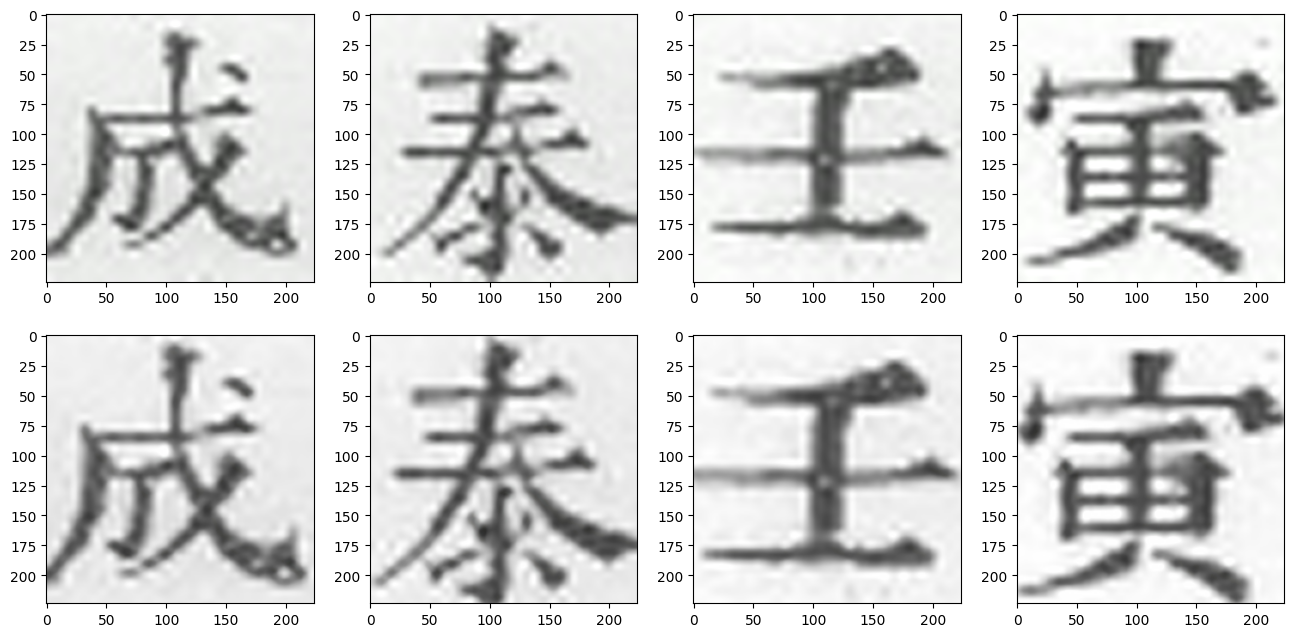

In [ ]:
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

DATASET_NAME = 'ToK1902'
dataset = NomImageDataset(
    image_dir = f'/content/dataset/{DATASET_NAME}_crops/{DATASET_NAME}_crops',
    annotation_file = f'/content/dataset/{DATASET_NAME}_crops/ToK1902_crops.txt',
    unicode_dict_path = UCODE_DICT,
    # scale=SCALE,
    image_size=(32, 32),
    transform = None,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

label_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    tmp = pickle.load(f)
for idx, (k, v) in enumerate(tmp.items()):
    label_dict[idx] = k

sample = next(iter(dataloader))
plt.figure(figsize=(16, 16))

pad = 8

for i in range(4):
    plt.subplot(4, 4, i+1)
    img = sample[0][i].permute(1, 2, 0).numpy() * 255
    img = img.clip(0, 255).astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    # img = cv2.copyMakeBorder(img,  cv2.BORDER_CONSTANT, value=0)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    plt.imshow(img)




    input_tensor = F.interpolate(sample[0][i].unsqueeze(0), size=(224, 224), mode='bicubic')
    input_tensor = input_tensor.to(DEVICE)
    with torch.no_grad():
        sr_img = sr_model(input_tensor)
        sr_img = F.interpolate(sr_img, size=(224, 224), mode='bicubic')
    sr_img = sr_img.cpu().squeeze(0).permute(1, 2, 0).numpy() * 255
    sr_img = sr_img.clip(0, 255).astype('uint8')
    # print(img.shape)
    sr_img = cv2.cvtColor(sr_img, cv2.COLOR_YCrCb2RGB)

    #     print(sr_img.shape)
    # # Take first 3 channel
    plt.subplot(4, 4, i+5)
    plt.imshow(sr_img)

    # plt.title(sample[1][i].item())
    try:
        print(chr(int(label_dict[sample[1][i].item()], 16)), end=' ')
    except:
        print('UNK', end=' ')

    # break
plt.show()

## Test on Raw images

In [ ]:
torch.cuda.clear_cache()
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        # Essentially normal Resnet operation is inference on bicubic upscaled images
        bicubic_imgs = F.interpolate(imgs, size=(224, 224), mode='bicubic')
        bicubic_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(bicubic_imgs)


        preds = recognizer_model(bicubic_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)

        correct_pred += torch.sum(preds == labels).item()
        # Record failure cases
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred != label:
                incorrect_pred.append((f'{idx}_{i}', pred, label))
        pbar.update(1)

pbar.close()
print("\nAccuracy:", correct_pred / len(dataset))

## Test on SR images

In [ ]:
torch.cuda.empty_cache()
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    imgs = F.interpolate(imgs, size=(224, 224), mode='bicubic')

    with torch.no_grad():
        sr_imgs = sr_model(imgs)
        sr_imgs = F.interpolate(sr_imgs, size=(224, 224), mode='bicubic')


        # print(sr_imgs.shape)
        sr_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(sr_imgs)

        preds = recognizer_model(sr_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)

        correct_pred += torch.sum(preds == labels).item()
        # Record failure cases
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred != label:
                incorrect_pred.append((f'{idx}_{i}', pred, label))
    pbar.update(1)

pbar.close()
print("\nAccuracy:", correct_pred / len(dataset))


Testing: 100%|██████████| 452/452 [01:43<00:00,  4.36it/s]


Accuracy: 0.5442214532871972
